This notebook shows the steps of extracting ASTs, building the dataset on Pytorch Geometric and then applying GNN model for graph embedding as well as predicting

In [1]:
import torch
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score
from torch_geometric.data import Dataset

In [2]:
import clang.cindex
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino'], 'size'   : 24})
rc('text', usetex=True)

In [3]:
import matplotlib
matplotlib.font_manager._rebuild()

Uploading a processed CWE type:

In [4]:
vdisc = pd.read_csv("./Dataset/vdisc_CWE_119.csv.gz")
vdisc["bug"] = vdisc["bug"].astype(int)

In [5]:
vdisc.head()

,Unnamed: 0,testCase_ID,filename,code,bug,type
0,0,0,0_vdisc.c,CDE_create_path_symlink_dirs() {\n char *p;\n...,1,CWE_119
1,1,1,1_vdisc.c,"gperror(unsigned int code,\n\t char *messa...",1,CWE_119
2,2,2,2_vdisc.c,test_date_rfc2822__format_rfc2822_positive_off...,1,CWE_119
3,3,3,3_vdisc.c,"toggle_cb (GtkWidget *item, char *pref_name)\n...",1,CWE_119
4,4,4,4_vdisc.c,"fixgrid34(NCDAPCOMMON* nccomm, CDFnode* grid)\...",1,CWE_119


In [6]:
vdisc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48314 entries, 0 to 48313
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   48314 non-null  int64 
 1   testCase_ID  48314 non-null  int64 
 2   filename     48314 non-null  object
 3   code         48314 non-null  object
 4   bug          48314 non-null  int64 
 5   type         48314 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.2+ MB


Extracting AST

In [7]:
def save_ast(node):
   
    node.children = list(node.get_children())

    for child in node.children:
        counter = save_ast(child)

In [8]:
def numbering_ast_nodes(node, counter=1):
  
    node.identifier = counter
    counter += 1

    node.children = list(node.get_children())
    for child in node.children:
        counter = numbering_ast_nodes(child, counter)

    return counter

In [9]:
def generate_edgelist(ast_root):
  
    edges = [[],[]]

    def walk_tree_and_add_edges(node):
        for child in node.children:
            # edges.append([node.identifier, child.identifier])
            # walk_tree_and_add_edges(child)
            edg_0 = (node.identifier)-1
            edg_1 = (child.identifier)-1
            # edges[0].append(node.identifier)
            # edges[1].append(child.identifier)
            edges[0].append(edg_0)
            edges[1].append(edg_1)
            walk_tree_and_add_edges(child)

    walk_tree_and_add_edges(ast_root)
    return  torch.tensor(edges, dtype=torch.long)

In [10]:
def generate_features(ast_root):
  
    features = []

    def walk_tree_and_set_features(node):
        out_degree = len(node.children)
        #in_degree = 1
        #degree = out_degree + in_degree
        degree = out_degree 
        node_id = node.identifier
        features.append([node_id, degree])

        for child in node.children:
            walk_tree_and_set_features(child)

    walk_tree_and_set_features(ast_root)

    features_array = np.asarray(features)
    # nodes_tensor = torch.from_numpy(features_array).float()
    nodes_tensor = torch.tensor(features_array, dtype=torch.float)
    # nodes_tensor = torch.LongTensor(features).unsqueeze(1)
    return nodes_tensor

In [11]:
def clang_process(testcase, **kwargs):
 
    parse_list = [
        (testcase.filename, testcase.code)
        
    ]

    # source_file= get_source_file(testcase)

    # Parsing the source code and extracting AST using clang
    index = clang.cindex.Index.create()
    translation_unit = index.parse(
        path=testcase.filename,
        unsaved_files=parse_list,
    )
    ast_root = translation_unit.cursor

    save_ast(ast_root)
    numbering_ast_nodes(ast_root)

    graphs_embedding = generate_edgelist(ast_root)

    nodes_embedding = generate_features(ast_root)
   

    y = torch.tensor([testcase.bug], dtype=torch.int64)



    # delete clang objects
    del translation_unit
    del ast_root
    del index

    return Data(x=nodes_embedding, edge_index=graphs_embedding, y=y)

Building the dataset on Pytorch geometrics

In [13]:
class MyOwnDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(MyOwnDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return 'not_implemented.pt'

    def download(self):
        # Download to `self.raw_dir`.
        pass

    def process(self):
        self.data = pd.read_csv("./Dataset/vdisc_CWE_119.csv.gz")
        for index, vuln in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            data = clang_process(vuln)
            torch.save(data, os.path.join(self.processed_dir, f'data_{index}.pt'))

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))
        return data

In [14]:
dataset = MyOwnDataset(root='./Dataset/')

Processing...


100%|██████████| 48314/48314 [03:01<00:00, 265.75it/s]

Done!


In [15]:
len(dataset)

48314

In [16]:
print(f'Number of features: {dataset.num_features}')

Number of features: 2


In [17]:
data1 = dataset[2]  # Get the first graph object.
print(f'Number of nodes: {data1.num_nodes}')
print(f'Number of edges: {data1.num_edges}')

Number of nodes: 5
Number of edges: 4


In [18]:
print(dataset[2].edge_index.t())

tensor([[0, 1],
        [1, 2],
        [2, 3],
        [3, 4]])


In [19]:
print(dataset[2].x)

tensor([[1., 1.],
        [2., 1.],
        [3., 1.],
        [4., 1.],
        [5., 0.]])


In [20]:
print(dataset[2].y)

tensor([1])


Split up the dataset

In [21]:
dataset = dataset.shuffle()
#one_tenth_length = int(len(dataset) * 0.1)
one_tenth_length = int(len(dataset) * 0.1)
train_dataset = dataset[:one_tenth_length * 8]
val_dataset = dataset[one_tenth_length*8:one_tenth_length * 9]
test_dataset = dataset[one_tenth_length*9:]
#test_dataset = dataset[one_tenth_length*8:one_tenth_length * 10]
len(train_dataset), len(val_dataset), len(test_dataset)
#len(train_dataset), len(test_dataset)

(38648, 4831, 4835)

In [22]:
from torch_geometric.data import DataLoader
NUM_GRAPHS_PER_BATCH = 256
train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH,drop_last=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=NUM_GRAPHS_PER_BATCH,drop_last=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH,drop_last=True, shuffle=True)

Building the GNN model

In [23]:
import torch
from torch.nn import Linear, Dropout
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 128
class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(dataset.num_features, embedding_size) #to  translate our node features into the size of the embedding
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        # pooling layer
        #self.pool = TopKPooling(embedding_size, ratio=0.8)
        #dropout layer
        #self.dropout = Dropout(p=0.2)

        # Output layer
        self.lin1 = Linear(embedding_size*2, 128) # linear output layer ensures that we get a continuous unbounded output value. It input is the flattened vector (embedding size *2) from the pooling layer (mean and max)
        self.lin2 = Linear(128, 128)
        self.lin3 = Linear(128, 1)

        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)

        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)
        #hidden = self.dropout(hidden)
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)
        # Apply a final (linear) classifier.
        out = self.lin1(hidden)
        out = self.act1(out)
        out = self.lin2(out)
        out = self.act2(out)
        #out = F.dropout(out, p=0.5, training=self.training)
        out = self.lin3(out)
        out = torch.sigmoid(out)

        # return out, hidden
        return out

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters())) 

GCN(
  (initial_conv): GCNConv(2, 128)
  (conv1): GCNConv(128, 128)
  (conv2): GCNConv(128, 128)
  (lin1): Linear(in_features=256, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=1, bias=True)
  (act1): ReLU()
  (act2): ReLU()
)
Number of parameters:  82945


In [24]:
def train():
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x.float(), data.edge_index, data.batch)
        label = data.y.to(device)
        #loss = torch.sqrt(loss_fn(output, label))  
        loss = loss_fn(output.squeeze(), label.float())  
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)

In [25]:
from sklearn.metrics import roc_auc_score
def evaluate(loader):
    model.eval()

    predictions = []
    labels = []

    with torch.no_grad():
        for data in loader:

            data = data.to(device)
            # pred = model(data.x.float(), data.edge_index, data.batch).detach().cpu().numpy()
            pred = model(data.x.float(), data.edge_index, data.batch)
            label_true = data.y.to(device)
            label = data.y.detach().cpu().numpy()
            # predictions.append(pred)
            # labels.append(label)
            predictions.append(np.rint(pred.cpu().detach().numpy()))
            labels.append(label)
            loss = loss_fn(pred.squeeze(), label_true.float())
    # predictions = np.hstack(predictions)
    # labels = np.hstack(labels)
    predictions = np.concatenate(predictions).ravel()
    labels = np.concatenate(labels).ravel()

    # print(predictions)
    # print(labels)
    return accuracy_score(labels, predictions), loss
    

Training the model

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss_fn = torch.nn.BCELoss()


print("Starting training...")
train_losses = []
val_losses = []
val_acc_list= []
train_acc_list= []
best_loss = 1000
early_stopping_counter = 0
for epoch in range(200):
    if early_stopping_counter <=  5: # = x * 5 
        loss = train()
        train_losses.append(loss)
        train_acc, train_loss = evaluate(train_loader)
        #val_acc = evaluate(val_loader)    
        val_acc, val_loss = evaluate(val_loader)
        val_losses.append(val_loss)
        val_acc_list.append(val_acc)
        train_acc_list.append(train_acc)
    
        if float(val_loss) < best_loss:
            best_loss = val_loss
            # Save the currently best model 
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        print(f"Epoch {epoch} | Train Loss {loss} | Train Accuracy{train_acc} | Validation Accuracy{val_acc} | Validation loss{val_loss}")

    else:
        print("Early stopping due to no improvement.")
        break
print(f"Finishing training with best val loss: {best_loss}")

Starting training...
Epoch 0 | Train Loss 0.6144500808226251 | Train Accuracy0.6822135416666667 | Validation Accuracy0.6736111111111112 | Validation loss0.5998484492301941
Epoch 1 | Train Loss 0.5824475502577955 | Train Accuracy0.6945572916666667 | Validation Accuracy0.6905381944444444 | Validation loss0.591886043548584
Epoch 2 | Train Loss 0.5750601773823647 | Train Accuracy0.7051302083333333 | Validation Accuracy0.7003038194444444 | Validation loss0.5541628003120422
Epoch 3 | Train Loss 0.5631807007865614 | Train Accuracy0.7145833333333333 | Validation Accuracy0.7152777777777778 | Validation loss0.5898100733757019
Epoch 4 | Train Loss 0.5562117595747622 | Train Accuracy0.708515625 | Validation Accuracy0.7102864583333334 | Validation loss0.5421066880226135
Epoch 5 | Train Loss 0.5503564470180985 | Train Accuracy0.7259375 | Validation Accuracy0.7289496527777778 | Validation loss0.55777907371521
Epoch 6 | Train Loss 0.5475679643157599 | Train Accuracy0.72390625 | Validation Accuracy0.72

Plotting the learning curves

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


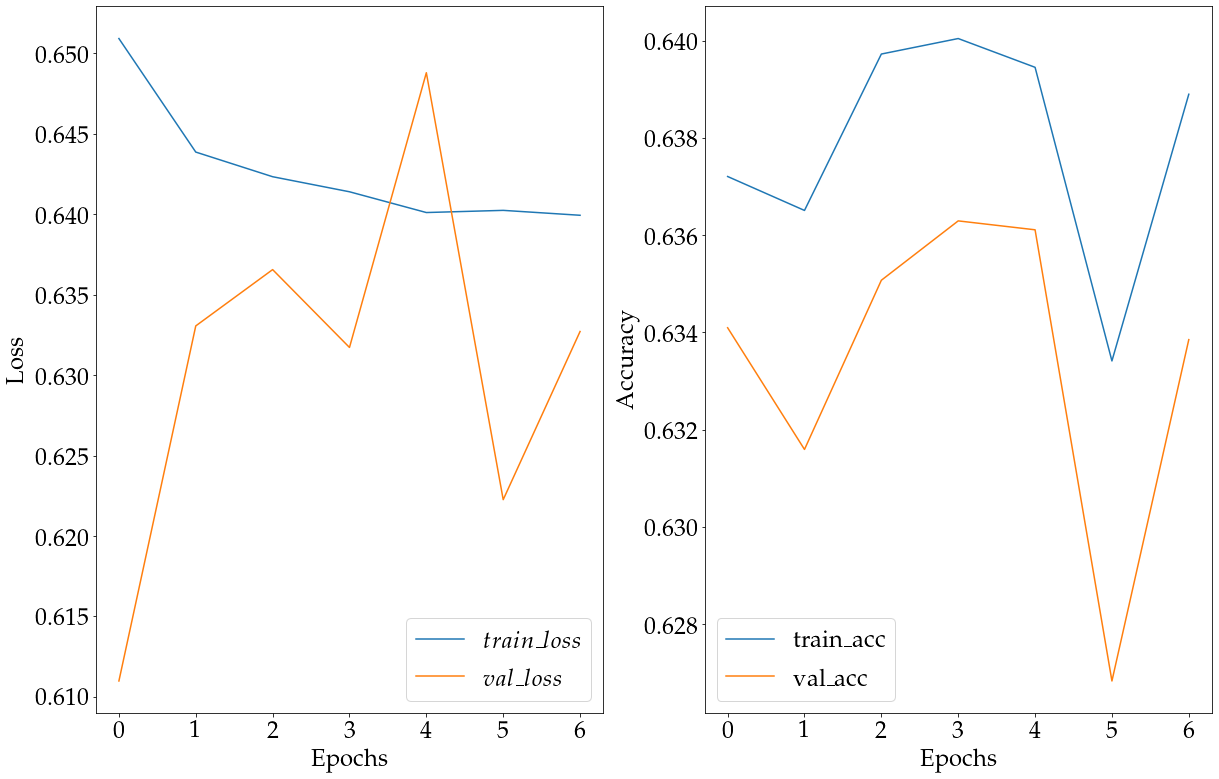

In [32]:
with torch.no_grad():
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 13))
    ax1.plot(train_losses, label="$train\_loss$")
    ax1.plot(val_losses, label="$val\_loss$")
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epochs')
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='best')

    ax2.plot(train_acc_list, label='train\_acc')
    ax2.plot(val_acc_list, label='val\_acc')
    ax2.legend()
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epochs')
    #plt.rc('font', family='serif')
    plt.savefig('CWE_COMBINED_gnn_losses.png')

<AxesSubplot:>

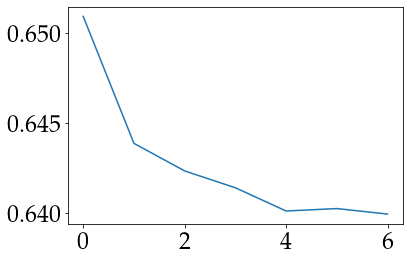

In [33]:
# Visualize learning (training loss)
import seaborn as sns
losses_float = [float(loss) for loss in train_losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

Printing out the performance metrics

In [27]:
NUM_GRAPHS_PER_BATCH_1 = 4835
test_loader_all = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH_1,drop_last=True, shuffle=True)

In [28]:
# Analyze the results for all graphs
test_batch = next(iter(test_loader_all))
with torch.no_grad():
    test_batch.to(device)
    pred = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    accuracy= accuracy_score(test_batch.y, np.rint(pred))
    precision= precision_score(test_batch.y, np.rint(pred), zero_division=1)
    recall= recall_score(test_batch.y, np.rint(pred), zero_division=1)
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
    print(f"\n Confusion matrix: \n {confusion_matrix(test_batch.y, np.rint(pred))}")
    print(f"\n Accuracy: {accuracy_score(test_batch.y, np.rint(pred))}")
    print(f"\n Precision: {precision_score(test_batch.y, np.rint(pred))}")
    print(f"\n Recall: {recall_score(test_batch.y, np.rint(pred))}")
    print(f"\n F1 Score: {f1_score(test_batch.y, np.rint(pred))}")
df


 Confusion matrix: 
 [[1620  844]
 [ 461 1910]]

 Accuracy: 0.7300930713547052

 Precision: 0.6935366739288308

 Recall: 0.8055672711935892

 F1 Score: 0.7453658536585365


,y_real,y_pred
0,1,[0.4110952913761139]
1,1,[0.6756953597068787]
2,0,[0.11998370289802551]
3,0,[0.7369117140769958]
4,0,[0.13293148577213287]
...,...,...
4830,1,[0.12243560701608658]
4831,1,[0.8020007014274597]
4832,0,[0.5188013911247253]
4833,1,[0.6873726844787598]
